In [1]:
import pandas as pd
import numpy as np
import pyodbc  
from datetime import datetime 
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller # stationary or not 
from statsmodels.stats.diagnostic import acorr_ljungbox # white noice test
from statsmodels.tsa.stattools import arma_order_select_ic # AIC BIC
import statsmodels.api as sm # predict
from scipy import  stats
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
import warnings
from sklearn.metrics import r2_scoregi
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings('ignore')
from fbprophet import Prophet

C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=htian;PWD=HeLeNtIAn52!")
cursor = conn.cursor()

In [3]:
DF = pd.read_sql("SELECT S.CustomerID, C.Customer, S.OrderDate, S.Requested_Date, S.SalesOffice, S.OrderQty, P.ProductCategory, P.MasterSKU,S.sourcesystem FROM EDW_DS.ORDERFCT S  inner join [EDW].[PRODUCT_DIM] P ON P.ProductID = S.ProductID  left join EDW_DS.CUSTOMER_DIM C on S.CustomerID = C.CustomerID WHERE P.ISCORE = 'TRUE' and S.SalesOffice in ('STD','HYB')  and S.RejectionReason is null and S.Ordertype Not in ('ZARF','ZARM','ZEG2','ZERF','ZERM','ZRE') and S.SoldtoParty not in ('91860','0000107894','0000114883','0000108654')", conn)


In [4]:
seg = pd.read_csv('C:/Users/Helen.Tian/Order_All_Segment_time_series/Volume_OrderFct.csv',dtype = {'CustomerID': str})[['CustomerID','Class']]

In [5]:
DF['OrderDate'] = pd.to_datetime(DF['OrderDate']) 

In [6]:
DF['Requested_Date'] = pd.to_datetime(DF['Requested_Date'])  

In [7]:
DF.isnull().sum()

CustomerID           0
Customer             0
OrderDate            0
Requested_Date     127
SalesOffice          0
OrderQty             0
ProductCategory      0
MasterSKU            0
sourcesystem         0
dtype: int64

In [8]:
DF=DF.fillna(0)

In [9]:
# 4% Requested_Date earlier than OrderDate
Date = []
for i in range(len(DF)):
    if DF.Requested_Date.iloc[i]==0: 
        Date.append(DF.OrderDate.iloc[i])
    elif DF.OrderDate.iloc[i]>DF.Requested_Date.iloc[i]:
        Date.append(DF.OrderDate.iloc[i])
    else:
        Date.append(DF.Requested_Date.iloc[i])
DF['Date']=Date

In [10]:
DF=DF[['CustomerID','Date', 'SalesOffice', 'OrderQty', 'ProductCategory', 'MasterSKU']]

In [11]:
DF = DF.sort_values(by=["Date"])

In [12]:
DF=DF[(DF.Date<='2018-5-31') & (DF.Date>='2014-1-01')]

In [13]:
data = pd.merge(DF, seg,  on='CustomerID', how='left')

In [14]:
data.isnull().sum()

CustomerID         0
Date               0
SalesOffice        0
OrderQty           0
ProductCategory    0
MasterSKU          0
Class              0
dtype: int64

In [15]:
def day2month(data):
    data.copy()
    o=[str(x.year)+'-'+str(x.month) for x in data.Date]
    data.Date=[datetime.strptime(x,'%Y-%m')for x in o] 
    return data

# 1 ) Select Time period for train/test, MasterSKU and Class (0,1,2,3,4)

Select MasterSKU and Class, transform data from day to month and group data in same month together

In [16]:
def select(data, cut, MasterSKU, Class):
    data1 = data[(data.MasterSKU==MasterSKU)&(data.Class==Class)]
    df = day2month(data1[(data1.Date<=cut)])
    dft = day2month(data1[(data1.Date>cut)])
    
    DW1=df.groupby('Date')['OrderQty'].sum()
    DW1=DW1.to_frame(name = 'DW').reset_index()
    DW1=DW1.set_index(DW1.Date)
    dw=DW1['DW'].astype(float)
    
    DWT=dft.groupby('Date')['OrderQty'].sum()
    DWT=DWT.to_frame(name = 'DW').reset_index()
    DWT=DWT.set_index(DWT.Date)
    dwt=DWT['DW'].astype(float)
    
    
    
    return (dw,dwt)

fill missing value with 0

In [17]:
def fill0(data,time):
    for date in time:
        if date not in data.index.values:
            data.loc[date] = 0
    data = data.sort_index()
    return data

Check is there any missing data in the set. If yes, fill with 0

In [18]:
def check(result,cut):
    TRA=select(data, cut, 'Roadie 20', 3)[0].index.values
    TES=select(data, cut, 'Roadie 20', 3)[1].index.values
    if len(result[0])<len(TRA):
        R1=fill0(result[0],TRA)
    else:
        R1=result[0]
    if len(result[1])<len(TES):
        R2=fill0(result[1],TES)
    else:
        R2=result[1]
    return (R1,R2)

# Time series functions

In [ ]:
# use basic test and plot to better understand the dataset

In [22]:
def basic(data):
    fig = plt.figure(figsize=(12, 8))
    plt.plot(data,color='gray',linestyle='--',marker='o')
    plt.grid()
    
    print("######################") 
    noiseRes = acorr_ljungbox(data, lags=1)
    print ('result of white noice testing (p-value should be small, otherwise: No information in this dataset)')
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
        
    print("######################")   
    
    def test_stationarity(timeseries):

        #Determing rolling statistics
        rolmean = pd.rolling_mean(timeseries, window=12)
        rolstd = pd.rolling_std(timeseries, window=12)

        #Plot rolling statistics:
        fig = plt.figure(figsize=(12, 8))
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show()
    
        #Perform Dickey-Fuller test:
        print ('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput) 
    
    test_stationarity(data)
    
    print("######################") 
    # acf
    plot_acf(data).show() 
   
    
    #pacf
    plot_pacf(data).show() 
   

# ARIMA
# 1. order select

In [ ]:
#Testing all model with different order value p,d,q and find the model with lowest mean squared error and AIC, BIC value

In [23]:
def arima(maxorder,diff, data,test): # diff is a list contains all possible diff
    p = q = range(0, maxorder) 
    d = diff
    pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
    res=pd.DataFrame(columns=['Param','mse','AIC','BIC'])
    
    for param in pdq:
        try:
            mod = ARIMA(data.values,param)                                 
            results = mod.fit()
                
            
            # predict and add test to compare
            predicts = results.forecast(steps=len(test))[0]
            
            rms = sqrt(mean_squared_error(test, predicts))
            res=res.append({'Param':param,'mse':rms,'AIC':results.aic,'BIC':results.bic}, ignore_index=True)
          #  print (param,results.aic,results.bic,rms)
        except:
            continue
    res1 = res.sort_values(by=["mse"])[:2]    # output 2 models with lowest Mean Squared Error
    res2 = res.sort_values(by=["AIC"])[:2]    # output 2 models with lowest AIC value
    res3 = res.sort_values(by=["BIC"])[:2]    # output 2 models with lowest BIC value
    print(res1)
    print(res2)
    print(res3)

# 2. Testing


In [ ]:
# output the plot of prediction and white noice check 

In [24]:
def ARIMA_modeling(data,order,test): 
    tempModel = ARIMA(data.values,order).fit() # fit the value into model
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    print("QQ plot of residuals (should be like a straight line)")
    fig = qqplot(tempModel.resid, line='q', ax=ax, fit=True)
    print("######################")
    noiseRes = acorr_ljungbox(tempModel.resid, lags=1)
    print ("result of residual's white noice testing (should be very large)")
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
    print("######################")
    predicts = tempModel.forecast(steps=len(test))[0]
    pred_CI = tempModel.forecast(steps=len(test))[2]
    low,high = [],[]
    for i in range(len(pred_CI)):
        low.append(pred_CI[i][0])
        high.append(pred_CI[i][1])
        
        
    comp = pd.DataFrame()
    comp['original'] = test
    comp['predict'] = predicts
    comp['low'] = low
    comp['high'] = high
    comp.plot()
    
    print("######################")
    rms = sqrt(mean_squared_error(test, predicts))
    print('mean squared error: ', rms)
    print("######################")
    q=((comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average Delta: ',np.mean(abs(q)), '%')

# SARIMA
# 1.order select

In [ ]:
# Test all model with different order value p,d,q P,D,Q,S and out put models with lowest mean squared error and AIC, BIC value

In [25]:
def sarima(maxorder,diff,seasonal,data,test):
    p = q = range(0, maxorder) 
    d = diff
    pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
    

    res=pd.DataFrame(columns=['Param','Seasonal_param','mse','AIC','BIC'])
    
    for season in seasonal:
        pdq_x_PDQs = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
    
    
        for param in pdq:
            for seasonal_param in pdq_x_PDQs:
                try:
                    mod = sm.tsa.statespace.SARIMAX(data.values,
                                                    order=param,
                                                    seasonal_order=seasonal_param,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = mod.fit()  
                
            
                   # predict and add test to compare
                    predicts = results.forecast(steps=len(test))
                    rms= sqrt(mean_squared_error(test, predicts))
          
                    res=res.append({'Param':param,'Seasonal_param':seasonal_param,'mse':rms,'AIC':results.aic,'BIC':results.bic}, ignore_index=True)
                    
                    
                except:
                    continue
    

    res1 = res.sort_values(by=["mse"])[:2]
    res2 = res.sort_values(by=["AIC"])[:2]
    res3 = res.sort_values(by=["BIC"])[:2]
    print(res1)
    print(res2)
    print(res3)

# 2. Testing

In [ ]:
# output the plot of prediction and white noice check 

In [26]:
def SARIMA_modeling(data,order,seasonal_order,test): 
    mod = sm.tsa.statespace.SARIMAX(data.values, 
                                  #  exog=exog.values,
                                order=order, 
                                seasonal_order=seasonal_order,   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary())
    print("######################")
    pred = results.forecast(steps=len(test))
    comp = pd.DataFrame()
    comp['original'] = test
    comp['predict'] = pred
    comp.plot()
    print("######################")
    rms = sqrt(mean_squared_error(test, pred))
    print('mean squared error: ', rms)
    print("######################")
    noiseRes = acorr_ljungbox(results.resid, lags=1)
    print ("result of residual's white noice testing (should be very large)")
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
    print("######################")
    print('residuals')
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    print("######################")
    q=((comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average Delta: ',np.mean(abs(q)), '%')

# Fbprophet

In [ ]:
# prophet output 

In [27]:
def prophet(train,test):
    X = pd.DataFrame(index=range(0,len(train)))
    X['ds'] = train.index
    X['y'] = train.values
    m = Prophet()
    m.fit(X)
    future_data = m.make_future_dataframe(periods=len(test), freq = 'm')
    forecast_data = m.predict(future_data)
    m.plot(forecast_data)
    predict=list(forecast_data['yhat'][-len(test):])
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = predict
    comp.plot()
    q=((comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average Delta: ',np.mean(abs(q)), '%')

# Naive

In [ ]:
# Naive model output

In [28]:
def Naive(train,test):
    data=list(train[-len(test):])
    r=[]
    for i in range(len(data)):
        r.append(np.mean(data[i:]+r))
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = r
    comp.plot()
    q=((comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average Delta: ',np.mean(abs(q)), '%')

# Modeling start....

In [34]:
# Choose a class and masterSKU and cut time

In [29]:
result = select(data,'2017-05-31','Tundra 45',1)

In [30]:
tra = result[0]   # training data
tes = result[1]   # testing data

In [31]:
len(tra),len(tes)

(41, 12)

In [105]:
# using plot to have a basic understand of data

######################
result of white noice testing (p-value should be small, otherwise: No information in this dataset)
stat                  | p-value
[9.70321636] |
[0.00183946] |
######################


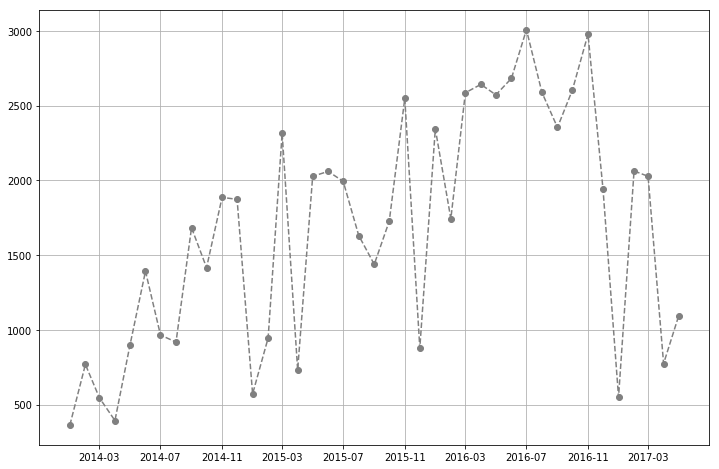

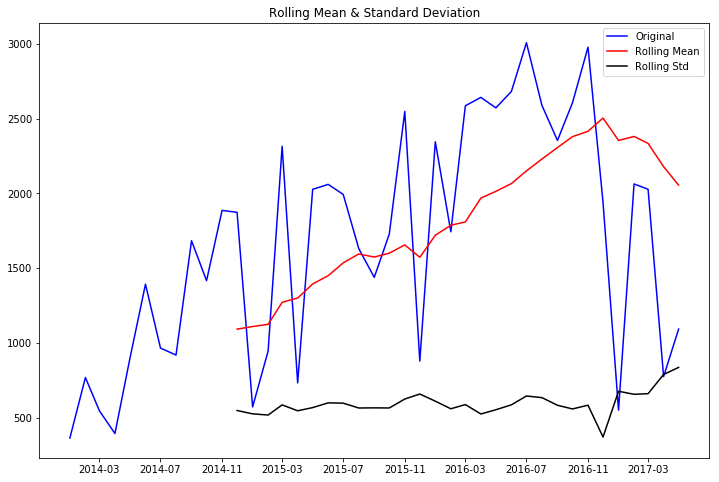

Results of Dickey-Fuller Test:
Test Statistic                 -1.961643
p-value                         0.303640
#Lags Used                      2.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64
######################


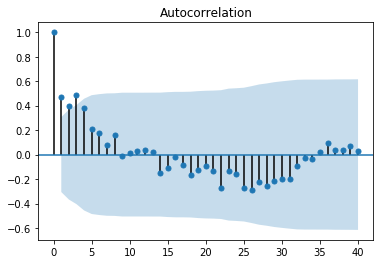

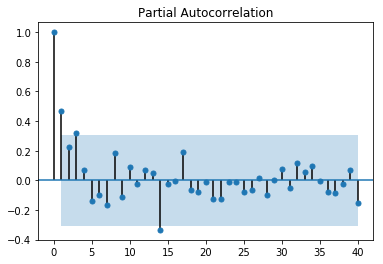

In [32]:
basic(tra)

In [ ]:
# evidence show this is not a stationary time series, redo basic function after differencing this time series

######################
result of white noice testing (p-value should be small, otherwise: No information in this dataset)
stat                  | p-value
[8.78002742] |
[0.00304547] |
######################


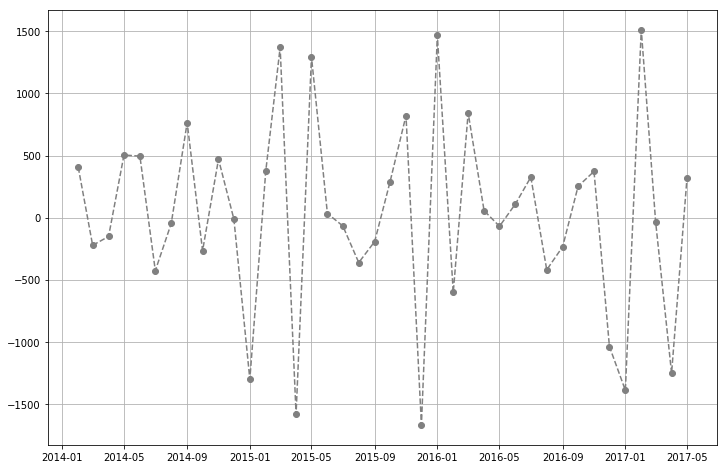

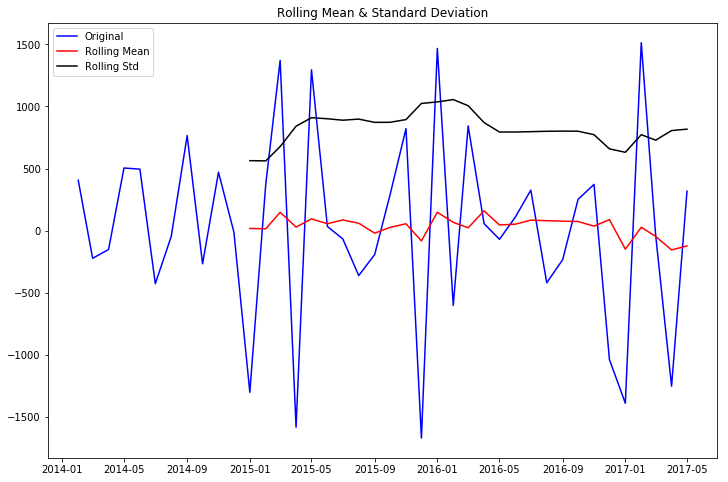

Results of Dickey-Fuller Test:
Test Statistic                -8.219407e+00
p-value                        6.490664e-13
#Lags Used                     1.000000e+00
Number of Observations Used    3.800000e+01
Critical Value (1%)           -3.615509e+00
Critical Value (5%)           -2.941262e+00
Critical Value (10%)          -2.609200e+00
dtype: float64
######################


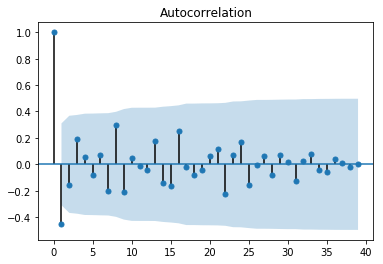

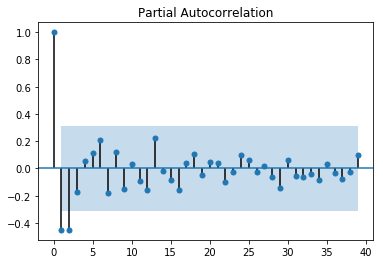

In [33]:
basic(tra.diff(1)[1:])

In [ ]:
# try different combination of order value, output the top 2 models with least mse, AIC, BIC

In [34]:
arima(10,[0,1,2], tra,tes)

        Param         mse         AIC         BIC
23  (2, 0, 1)  812.310619  654.571874  663.139734
13  (1, 0, 1)  812.416646  652.916832  659.771120
        Param          mse         AIC         BIC
30  (2, 2, 4)  1509.035196  625.068205  638.376698
38  (3, 2, 1)  1514.429480  625.135062  635.116432
        Param          mse         AIC         BIC
28  (2, 2, 1)  1595.716228  625.501756  633.819564
38  (3, 2, 1)  1514.429480  625.135062  635.116432
        Param          mse         AIC         BIC
28  (2, 2, 1)  1595.716228  625.501756  633.819564
38  (3, 2, 1)  1514.429480  625.135062  635.116432


In [ ]:
# output the result after prediction from ARIMA model

QQ plot of residuals (should be like a straight line)
######################
result of residual's white noice testing (should be very large)
stat                  | p-value
[0.10531128] |
[0.74554666] |
######################
######################
mean squared error:  812.3106189845555
######################
Date
2017-06-01    -27.491471
2017-07-01    -12.384954
2017-08-01     49.402645
2017-09-01     15.395965
2017-10-01     18.789077
2017-11-01    -61.739397
2017-12-01   -150.346950
2018-01-01   -126.368557
2018-02-01   -147.041359
2018-03-01   -127.821123
2018-04-01     28.489031
2018-05-01     56.039283
dtype: float64
average Delta:  68.44248449780294 %


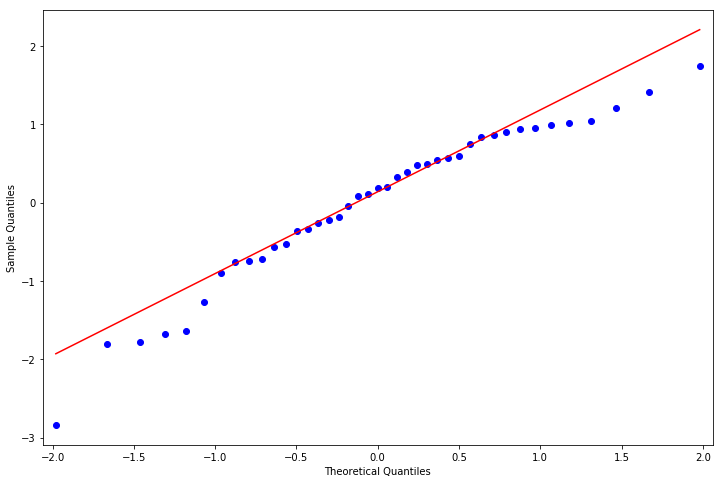

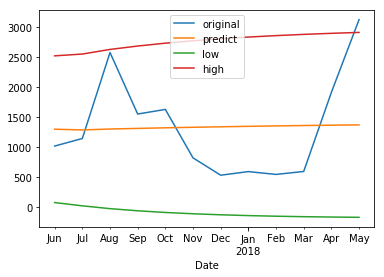

In [36]:
ARIMA_modeling(tra,(2, 0, 1),tes)

QQ plot of residuals (should be like a straight line)
######################
result of residual's white noice testing (should be very large)
stat                  | p-value
[0.35911429] |
[0.54899855] |
######################
######################
mean squared error:  812.4166462676923
######################
Date
2017-06-01    -30.035271
2017-07-01    -16.566709
2017-08-01     47.784370
2017-09-01     12.857150
2017-10-01     16.524354
2017-11-01    -65.948859
2017-12-01   -156.442001
2018-01-01   -131.537524
2018-02-01   -152.345566
2018-03-01   -132.432369
2018-04-01     27.121062
2018-05-01     55.242486
dtype: float64
average Delta:  70.40314339350404 %


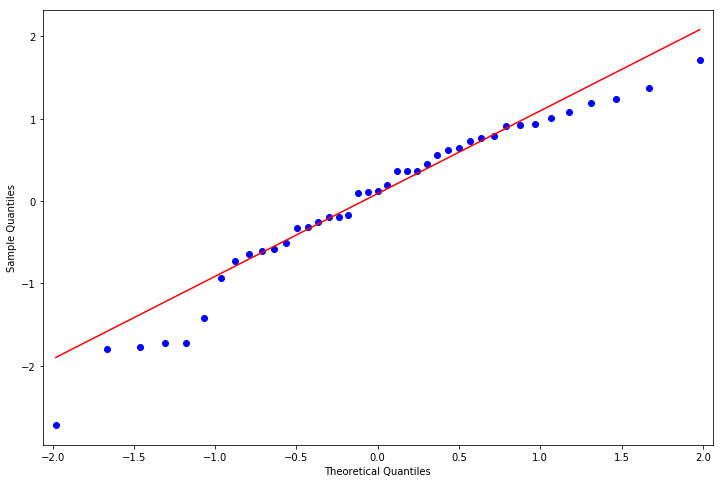

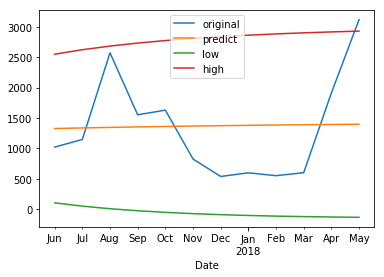

In [37]:
ARIMA_modeling(tra,(1, 0, 1),tes)

In [ ]:
# Start to modeling with Seasonal ARIMA model, seasonal value will be test from 0 to 13 (more than one year)

In [38]:
sarima(3, [0,1,2], range(0,13),tra,tes)

C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1043: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not params_seasonal_variance == []:
C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1042: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


          Param Seasonal_param         mse         AIC         BIC
5270  (0, 0, 2)   (1, 0, 0, 9)  693.900905  539.748406  546.602694
5501  (2, 0, 0)   (0, 1, 0, 9)  739.598002  504.426361  509.567078
          Param Seasonal_param          mse       AIC        BIC
6417  (1, 2, 1)  (1, 2, 0, 12)  4049.992037  6.407344  13.261632
5747  (1, 0, 0)  (2, 2, 0, 10)  2087.117974  8.000000  14.854288
          Param Seasonal_param          mse       AIC        BIC
6417  (1, 2, 1)  (1, 2, 0, 12)  4049.992037  6.407344  13.261632
5747  (1, 0, 0)  (2, 2, 0, 10)  2087.117974  8.000000  14.854288


In [ ]:
# see result from the best model

C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1042: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   41
Model:             SARIMAX(0, 0, 2)x(1, 0, 0, 9)   Log Likelihood                -265.874
Date:                           Tue, 17 Jul 2018   AIC                            539.748
Time:                                   17:01:58   BIC                            546.603
Sample:                                        0   HQIC                           542.244
                                            - 41                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2449      0.178      1.375      0.169      -0.104       0.594
ma.L2          0.2878      0.285      1.010

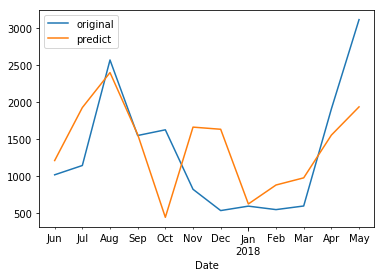

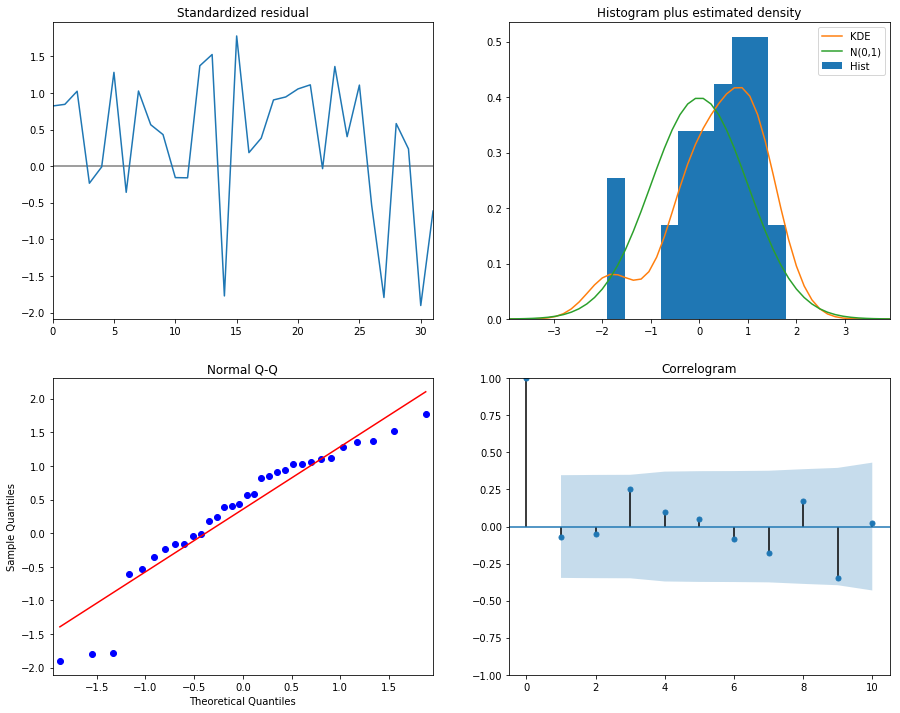

######################
Date
2017-06-01    -18.951152
2017-07-01    -68.453273
2017-08-01      6.621767
2017-09-01     -0.913827
2017-10-01     72.743566
2017-11-01   -102.236777
2017-12-01   -205.675555
2018-01-01     -4.950554
2018-02-01    -60.769190
2018-03-01    -63.805790
2018-04-01     18.527261
2018-05-01     37.851478
dtype: float64
average Delta:  55.12501589491353 %


In [43]:
SARIMA_modeling(tra,(0, 0, 2) ,  (1, 0, 0, 9) ,tes)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0    -177.522714
1    -141.752585
2       2.991094
3     -69.551572
4     -68.062222
5    -296.755044
6    -332.993342
7    -221.825003
8    -327.636276
9    -368.651564
10     -7.161531
11     16.149598
dtype: float64
average Delta:  169.2543788622833 %


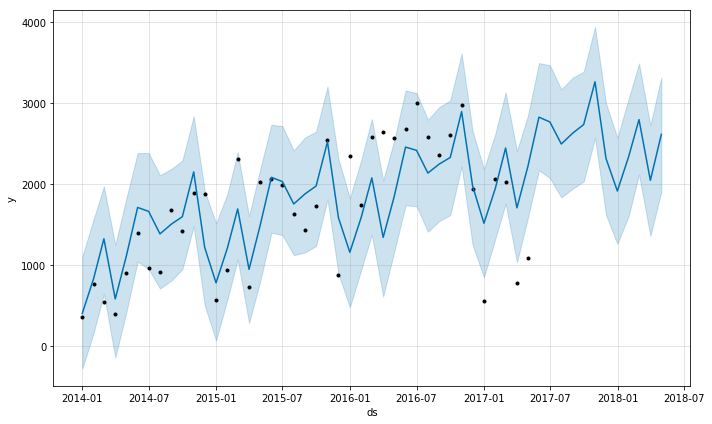

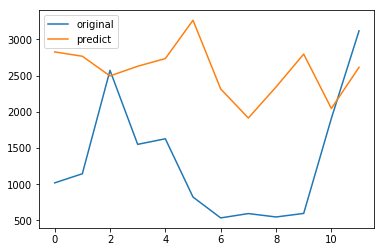

In [40]:
prophet(tra,tes)

0    -101.684658
1     -74.928433
2      25.411008
3     -20.144380
4     -11.950816
5    -113.520358
6    -209.447713
7    -174.258941
8    -214.232499
9    -183.681228
10     12.785776
11     44.209437
dtype: float64
average Delta:  98.85460392415638 %


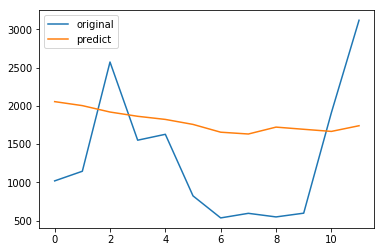

In [41]:
Naive(tra,tes)